In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib
#from ydata_profiling import ProfileReport
from torch.utils.data import DataLoader, Dataset
from PIL import Image
from IPython.display import display

# Librerías para el uso de imagenes
from ultralytics import YOLO
import cv2

In [2]:
train=pd.read_csv('../data/raw/train.csv')
valid=pd.read_csv('../data/raw/valid.csv')

In [21]:
train.head()

,Unnamed: 0,original_path,id,label,label_str,path
0,1052,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,28609,1,real,train/real/28609.jpg
1,13406,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,30395,1,real,train/real/30395.jpg
2,16376,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,22430,1,real,train/real/22430.jpg
3,31373,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,58380,1,real,train/real/58380.jpg
4,21034,/kaggle/input/flickrfaceshq-dataset-nvidia-par...,62044,1,real,train/real/62044.jpg


## Probamos YOLOv9 desde Ultralytics

In [4]:
# Importamos el modelo con pesos pre entrenados
model = YOLO('yolov9c.pt') # --> https://docs.ultralytics.com/es/models/yolov9/#generalized-efficient-layer-aggregation-network-gelan

In [5]:
# Vemos la información del modelo en cuestión
model.info()

YOLOv9c summary: 618 layers, 25590912 parameters, 0 gradients, 104.0 GFLOPs


(618, 25590912, 0, 104.02268160000003)

In [9]:
# Generamos un dataloader
class FacesDataset(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # columna 5 contiene el path relativo
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 5])
        image = Image.open(img_name)
        # columna 3 contiene el label numérico (real=1 | fake=0)
        label = self.dataframe.iloc[idx, 3]

        if self.transform:
            image = self.transform(image)

        return image, label


In [10]:
# custom datasets
train_dataset = FacesDataset(dataframe=train, root_dir='../data/raw/')
valid_dataset = FacesDataset(dataframe=valid, root_dir='../data/raw/')

# data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

Rostro REAL id 0:


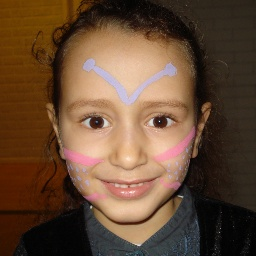

0: 640x640 1 person, 493.8ms
Speed: 2.5ms preprocess, 493.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Rostro REAL id 100:


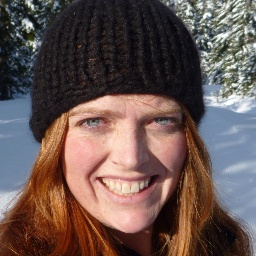


0: 640x640 1 person, 449.8ms
Speed: 2.1ms preprocess, 449.8ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)



Rostro REAL id 200:


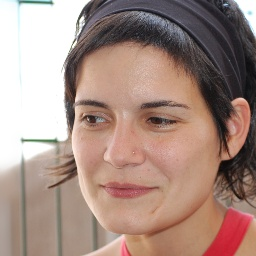


0: 640x640 1 person, 415.3ms
Speed: 1.9ms preprocess, 415.3ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



Rostro REAL id 300:


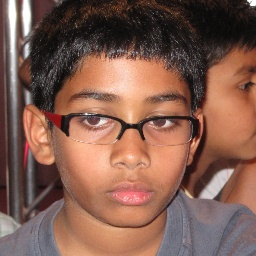


0: 640x640 2 persons, 423.4ms
Speed: 1.5ms preprocess, 423.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)



Rostro FAKE:


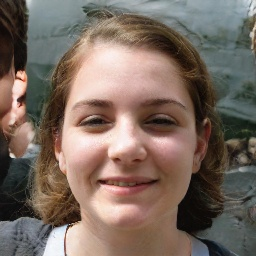


0: 640x640 3 persons, 420.2ms
Speed: 1.8ms preprocess, 420.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



Rostro FAKE:


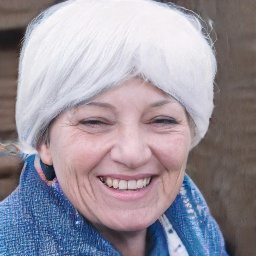


0: 640x640 1 person, 416.9ms
Speed: 1.7ms preprocess, 416.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)



Rostro FAKE:


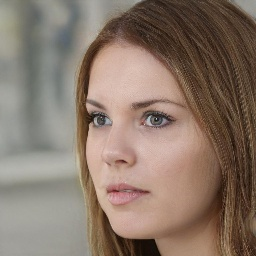


0: 640x640 1 person, 412.4ms
Speed: 1.9ms preprocess, 412.4ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)



Rostro FAKE:


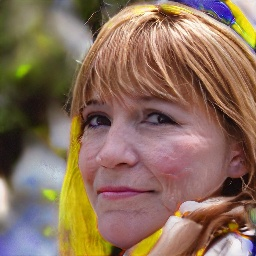


0: 640x640 1 person, 1 hot dog, 451.0ms
Speed: 1.5ms preprocess, 451.0ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)





In [47]:
# Vamos a ver si puede diferenciar entre imagenes reales o fakes
images_ids = [0,100,200,300,6000,6100,6200,6300]

for id in images_ids:
    image, label = train_dataset.__getitem__(id)
    print(f"Rostro REAL id {id}:" if label == 1 else "Rostro FAKE:")
    display(image)
    result = model(image)
    print(2*"\n")

#### Podemos sacar un par de conclusiones:
- El modelo realiza un resizing de las imágenes a 640x640.
- El modelo no puede distinguir la clase __person__ como la *real* y otra clase como la *fake*.